In [1]:
%matplotlib notebook

In [2]:
import torchvision
from torchvision.io.image import read_image
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torch
from torchvision import transforms

import cv2 as cv
from PIL import Image
import numpy as np

import glob

import time
import copy

from torchvision.models import vgg19_bn, VGG19_BN_Weights
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Step 1: Initialize model with the best available weights
weights = SSD300_VGG16_Weights.DEFAULT
# model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model = ssd300_vgg16(weights=weights)
# model.to('cuda')
model = model.eval()

In [16]:
def save_cropped_objects (filepath, num_imgs, id):
    img = read_image(filepath)
    img = img[:3,:,:]
    preprocess = weights.transforms()
    batch = [preprocess(img)]
    prediction = model(batch)[0]
    labels = [weights.meta["categories"][i] for i in prediction["labels"]]
    im = to_pil_image(img)
    for i in range(num_imgs):
        coords = prediction["boxes"][i+1].tolist()
        # print(coords)
        im1 = im.crop(coords)
        im1.save("cropped_imgs/" + str(id) + "_" + str(i) + ".jpg")

In [ ]:
save_cropped_objects("dataset/elephant.jpg", 5, 1)

In [ ]:
filepath = 'dataset/raw/train/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

filepath = 'dataset/raw/test/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

filepath = 'dataset/raw/valid/'
for i, filename in enumerate(glob.glob(filepath + '*.jpg')):
	save_cropped_objects(filename, 5, i)

In [17]:
filepath = 'alan_imgs/'
for i, filename in enumerate(glob.glob(filepath + '*.*')):
	save_cropped_objects(filename, 5, i)

# VGG Model

In [30]:
vggweights = VGG19_BN_Weights.DEFAULT
vggmodel = vgg19_bn(weights=vggweights)
vggmodel = vggmodel.eval()
vggmodel.to(device)
print()

In [21]:
class CustomImageDataset(Dataset):
    def __init__(self, numpydata, numpylabels, transform=None, target_transform=None):
        self.imgs = numpydata
        self.img_labels = numpylabels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        label = self.img_labels[idx]
        image = self.imgs[idx]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def padImage(img):
    imgshape = np.array(img.shape[:-1])
    
    padding = abs(imgshape[1]-imgshape[0])
    
    if imgshape[1] > imgshape[0]:
        pad1 = np.zeros((padding//2 + padding%2, imgshape[1],3), dtype=int)
        pad2 = np.zeros((padding//2, imgshape[1],3), dtype=int)
        
        img = np.vstack((pad1,img,pad2))
    if imgshape[0] > imgshape[1]:
        pad1 = np.zeros((imgshape[0], padding//2 + padding%2, 3), dtype=int)
        pad2 = np.zeros((imgshape[0], padding//2,3), dtype=int)
        
        img = np.hstack((pad1, img, pad2))

    return img

def fixImage(filename):
    img = padImage(np.array(cv.imread(filename))/255)
    img = cv.resize(img, (256,256), interpolation = cv.INTER_LINEAR)
    img = np.moveaxis(img, -1, 0)
    img = img.reshape(1,3,256,256)
    
    return img

In [22]:
yes_x = np.empty((1,3,256,256))
no_x = np.empty((1,3,256,256))

for filename in glob.glob('sorted_imgs/box/*.*'):
    img = fixImage(filename)
    no_x = np.concatenate((no_x, img))

for filename in glob.glob('sorted_imgs/no_box/*.*'):
    img = fixImage(filename)
    yes_x = np.concatenate((yes_x, img))

## Data Augmentation

In [18]:
# def show_dataset(dataset, n=6):
#   img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
#                    for i in range(len(dataset))))
#   plt.imshow(img)
#   plt.axis('off')

In [41]:
transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20),
    torchvision.transforms.ToTensor()
])
# datasets = {
#     'box': torchvision.datasets.ImageFolder('./sorted_imgs/box/', transform=transforms_pytorch),
#     'no_box': torchvision.datasets.ImageFolder('./sorted_imgs/no_box/', transform=transforms_pytorch)
# }
# for mode in ('box', 'no_box'):
#     show_dataset(datasets[mode])
folder_dataset = torchvision.datasets.ImageFolder('./sorted_imgs/', transform=transforms_pytorch)
print(len(folder_dataset))
for d in folder_dataset:
    i,c = d
    
#     d.save("sorted_imgs/aug_imgs/" + str(id) + "_" + str(i) + ".jpg")
# show_dataset(dataset)

59


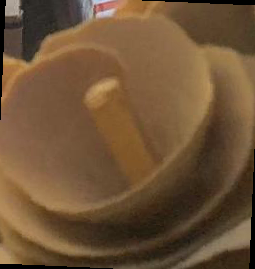

In [31]:
i

In [32]:
c

1

In [37]:
folder_dataset[1][1]

0

In [38]:
batch_size = 16

yes_x = yes_x[1:]
no_x = no_x[1:]

p_split = int(len(yes_x)*0.8)
np_split = int(len(no_x)*0.8)

train_x = np.vstack((no_x[:np_split], yes_x[:p_split]))
valid_x = np.vstack((no_x[np_split:], yes_x[p_split:]))

train_y = [0] * np_split + [1] * p_split
valid_y = [0] * (len(no_x) - np_split) + [1] * (len(yes_x) - p_split)

train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
valid_x = torch.tensor(valid_x, dtype=torch.float32, device=device)

train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
valid_y = torch.tensor(valid_y, dtype=torch.float32, device=device)

data = CustomImageDataset(train_x, train_y)
valid_data = CustomImageDataset(valid_x, valid_y)

trainloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loaders = {
    "train":trainloader,
    "val":valloader
}

NameError: name 'yes_x' is not defined

In [48]:
trainloader = torch.utils.data.DataLoader(folder_dataset, batch_size=1, shuffle=True)

In [49]:
for batch_img,batch_label in trainloader:
    break
batch_img.shape,batch_label.shape

(torch.Size([1, 3, 300, 537]), torch.Size([1]))

In [24]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./cropped_imgs"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)


# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long()
                
                #print(inputs.type())
                #print(labels.type())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vggmodel.parameters(), lr=0.001)

# train_model(
#     model,
#     dataloaders,
#     criterion,
#     optimizer,
#     num_epochs=25,
#     is_inception=False,
# )

model, val_acc_history = train_model(vggmodel, loaders, criterion, optimizer)

Epoch 0/24
----------
train Loss: 0.5815 Acc: 0.7049
val Loss: 36.2533 Acc: 0.8125

Epoch 1/24
----------
train Loss: 1.1257 Acc: 0.6721
val Loss: 6.9834 Acc: 0.8125

Epoch 2/24
----------
train Loss: 0.5163 Acc: 0.6721
val Loss: 4.1437 Acc: 0.6875

Epoch 3/24
----------
train Loss: 0.4784 Acc: 0.7049
val Loss: 90.8822 Acc: 0.8125

Epoch 4/24
----------
train Loss: 0.3721 Acc: 0.7869
val Loss: 17.9381 Acc: 0.8125

Epoch 5/24
----------
train Loss: 0.3445 Acc: 0.8361
val Loss: 1.8238 Acc: 0.6250

Epoch 6/24
----------
train Loss: 0.4849 Acc: 0.6885
val Loss: 0.4349 Acc: 0.7500

Epoch 7/24
----------
train Loss: 0.4025 Acc: 0.8525
val Loss: 1.4357 Acc: 0.4375

Epoch 8/24
----------
train Loss: 0.3527 Acc: 0.8033
val Loss: 0.3923 Acc: 0.6875

Epoch 9/24
----------
train Loss: 0.4465 Acc: 0.6885
val Loss: 0.4909 Acc: 0.6875

Epoch 10/24
----------
train Loss: 0.3355 Acc: 0.8361
val Loss: 0.9936 Acc: 0.4375

Epoch 11/24
----------
train Loss: 0.3345 Acc: 0.8361
val Loss: 0.6495 Acc: 0.4375


In [28]:
torch.save(model, "vggmodel.pb")